# __Desafío Técnico Salud Digital__
## Marcelo Torres Cisterna

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import CategoryAnalyzer , CategoryPlotter

El archivo se convirtió a formato __Pickle__ ya que por su gran tamaño, leerlo desde Excel toma mucho tiempo

In [2]:
data = pd.read_pickle("nsp.pkl")

## __Sección 1 y 2 : Exploratory Data Analysis (EDA) y Creación de Variables__

### __Sección 1.1 : EDA Rápido__

In [3]:
data.head(3)

,id,fechanacimiento,sexo,prevision,especialidad,tipoatencion,fechareserva,fechahoracita,nsp
0,e1f568d43f199d828c9462e05c784c16,1965-05-18,f,FONASA C,GINECOLOGIA - AGENDA MEDICA,NUEVO,2018-11-12,2018-11-27 11:00:00,0
1,600048a30420b4e18c0385a5ca185be5,1960-04-10,f,FONASA B,GINECOLOGIA - AGENDA MEDICA,NUEVO,2018-11-07,2018-11-16 11:00:00,0
2,dbe9285fa3633f6baea7e382e3f120d0,1992-02-02,f,FONASA B,OBSTETRICIA - AGENDA MEDICA,CONTROL,2018-10-30,2018-11-13 10:30:00,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 9 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   id               1048575 non-null  object        
 1   fechanacimiento  1048575 non-null  datetime64[ns]
 2   sexo             1048575 non-null  object        
 3   prevision        1048575 non-null  object        
 4   especialidad     1048575 non-null  object        
 5   tipoatencion     1048575 non-null  object        
 6   fechareserva     1048575 non-null  datetime64[ns]
 7   fechahoracita    1048575 non-null  datetime64[ns]
 8   nsp              1048575 non-null  int64         
dtypes: datetime64[ns](3), int64(1), object(5)
memory usage: 72.0+ MB


Lo primero que observamos es que se trata de un set de datos bastante grande con __1 millón de registros__. Por otra parte, extrañamente y digo extraño porque habitualmente no se da, el set __NO__ contiene datos faltantes, lo cual es bastante beneficioso. Sin embargo, hay que hacer una revisión ya que puede que implícitamente si existan nulos. ¿ A qué me refiero con esto ? Básicamente que si bien los registros no presentan nulos, puede que tengan campos como __"Desconocido"__ o __"No Informado"__.  

Algo que habitualmente realizo durante mis EDA en primera instancia es eliminar columnas que a priori se que son innecesarias. En el caso anterior, por ejemplo, la variable __id__ se que no me aporta ningún significado valioso, es simplemente un identificador. Sin embargo, en este caso en particular puede que sea de utilidad para identificar a ciertos pacientes que podrían aportar algún tipo de información, por lo que no la eliminaré de forma inmediata. Además, supongamos que este id es el rut del paciente. Si yo elimino la columna id y luego genero un drop_duplicates podría estar eliminando pacientes con iguales condiciones de ingreso, los cuales en teoría no serían duplicados como se indica a continuación:

In [5]:
print(f"Datos antes de filtrado por Duplicación : {data.shape}")
print(f"Datos después de filtrado por Duplicación : {data.drop_duplicates().shape}")
print(f"Datos Duplicados : {data.shape[0] - data.drop_duplicates().shape[0]}")

Datos antes de filtrado por Duplicación : (1048575, 9)
Datos después de filtrado por Duplicación : (1048575, 9)
Datos Duplicados : 0


Borramos id (sin inplace para no guardar cambios en memoria) y repetimos el comando:

In [6]:
noid_cols = ['fechanacimiento', 'sexo', 'prevision', 'especialidad','tipoatencion', 'fechareserva', 'fechahoracita', 'nsp']

In [7]:
print(f"Datos antes de filtrado por Duplicación : {data[noid_cols].shape}")
print(f"Datos después de filtrado por Duplicación : {data[noid_cols].drop_duplicates().shape}")
print(f"Datos Duplicados : {data[noid_cols].shape[0] - data[noid_cols].drop_duplicates().shape[0]}")

Datos antes de filtrado por Duplicación : (1048575, 8)
Datos después de filtrado por Duplicación : (1048144, 8)
Datos Duplicados : 431


Si yo eliminara la columna ID estaría eliminando 431 pacientes de forma equivacada. No es un gran daño al dataset considerando que es de 1 millón de registros, pero si es importante tener esto en futuros estudios

Cuando realizo mis EDA, me gusta ser visual. Una imagen vale más que mil palabras. Al tratarse de problemas del área de la salud es muy probable que exista algún __Desbalanceo__ de clases:

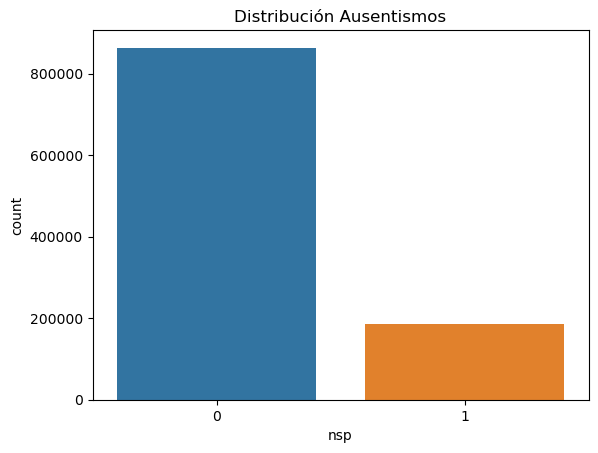

In [8]:
plt.title("Distribución Ausentismos")
sns.countplot(x = "nsp" , data = data);

In [9]:
data.value_counts("nsp")

nsp
0    863367
1    185208
dtype: int64

Y como era de esperarse hay un notorio desbalanceo. ¿En qué afecta esto? Principalmente en entrenar el modelo ya que al existir mayores pacientes de la clase 0, si llegamos y entrenamos el modelo, éste se va a enfocar en la clase con mayor predominancia y la que nos importa es la clase 1.  

### __Sección 1.2 : Analizando Variables En Detalles__

Una de las visualizaciones que más me gusta utilizar son los countplots y los histogramas, pero añadiendo el hiperparámetro __hue__ para identificar posibles patrones entre las variables explicativas y la que buscamos explicar

#### __Sección 1.2.1 : Tipo Atención__

El análisis de variables lo iniciaré con aquellas variables más sencillas de explicar y como son pocas, puedo analizarlas una por una. Había comenzado con un cierto orden, pero a medida que fui avanzando lo debí reacomodar.

In [11]:
data.value_counts("tipoatencion")

tipoatencion
CONTROL                      525996
NUEVO                        250674
EXAMENES DE LABORATORIO       57178
TRATAMIENTO ANTICOAGULANT     48747
AUTORIZADO CUADERNO           31873
URGENCIA                      27381
AUGE                          17383
HOSPITALIZADO                 14830
NIÑOS                         11798
COMGES                         6777
UCRI                           6306
CONTROLES DE URGENCIA          5012
ECO DUPLEX EXTREMIDADES        3739
OFTALMOLOGIA RETINA            3417
EMISIONES OTOACUSTICAS         3225
PABELLON                       2835
LASER                          2547
PREMATURO                      2462
ESPIROMETRIA                   2449
PRIVACION DE SUEÑO             2348
ARTRITIS                       2315
GASTRO CDT                     2253
CIRUGIA                        2126
RECETA                         2063
PREVENTIVAS                    1572
PVR                            1559
ADULTO                         1374
TEST DE CAMINAT

In [64]:
CategoryAnalyzer(data , "tipoatencion" , "nsp")

nsp,0,1,Tasa
tipoatencion,,,
PERITAJE NUEVO,87,65,42.76
AUTORIZADO CUADERNO,19503,12370,38.81
FUNCIONARIOS,124,74,37.37
ADULTO,984,390,28.38
FUNCION PULMONAR,471,184,28.09
TEST DE CAMINATA,882,276,23.83
PRIVACION DE SUEÑO,1796,552,23.51
NUEVO,194400,56270,22.45
METACOLINA,633,182,22.33


Primero, notamos que del millón de datos tenemos 1 solo paciente para __BIOPSIA__ y __MAXILOFACIAL__. Por lo mismo, los quitaremos del set de datos.

In [65]:
data = data[(data["tipoatencion"] != "BIOPSIA") & (data["tipoatencion"] != "MAXILOFACIAL")]

Notamos que hay dos atenciones con notorias tasas de ausentismos : __PERITAJE NUEVO__ y 
__AUTORIZADO CUADERNO__. El segundo concepto es encesario indagarlo ya que su nombre es un poco ambigüo

#### __Sección 1.2.2 : Sexo__

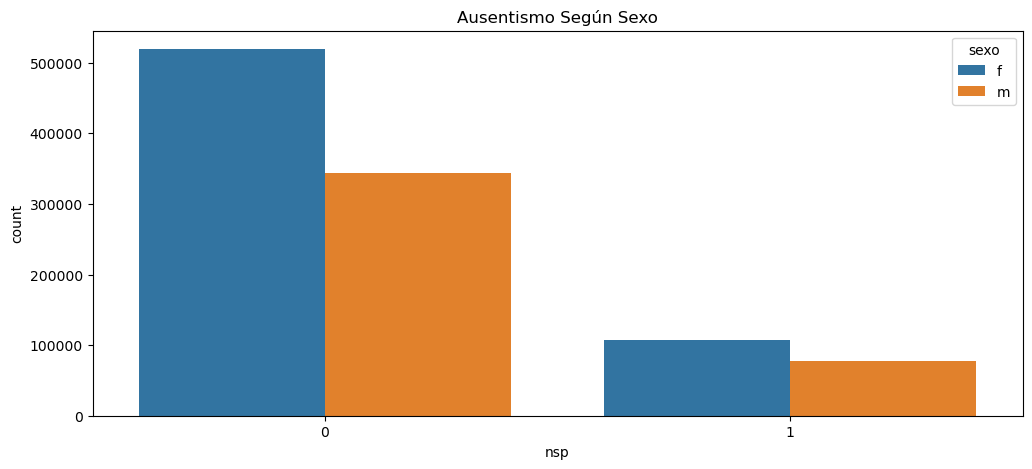

In [67]:
plt.figure(figsize = (12,5))
plt.title("Ausentismo Según Sexo")
sns.countplot(data = data, x='nsp' , hue = "sexo");

Notamos un leve ausentismo mayor en mujeres que en hombres. Sin embargo, no es algo tan notorio. De todas maneras esto no implica que debamos descartar la variable inmediatamente.

#### __Sección 1.2.2 : Especialidad__

Siguiendo con la variable __especialidad__ primero debemos analizar cuántas categorías tenemos. Esto lo podemos hacer fácilmente con el comando __unique__:

In [68]:
data.especialidad.unique().shape

(97,)

Notamos que hay una gran variedad de __97__ valores por lo que es una gran oportunidad para realizar un poco de __Feature Engineering__. Veamos algunos ejemplos de las especialidades:

In [69]:
data.especialidad.unique()[:30]

array(['GINECOLOGIA - AGENDA MEDICA', 'OBSTETRICIA - AGENDA MEDICA',
       'MEDICINA GENERAL - AGENDA MEDICA', 'ONCOLOGIA - AGENDA MEDICA',
       'OFTALMOLOGIA - AGENDA MEDICA',
       'TRAUMATOLOGIA Y ORTOPEDIA - AGENDA MEDICA',
       'REHABILITACION: PROTESIS REMOVIBLE - AGENDA ODONTOLOGO',
       'OPERATORIA - AGENDA ODONTOLOGO', 'HEMATOLOGIA - AGENDA MEDICA',
       'PEDIATRIA - AGENDA MEDICA', 'PSIQUIATRIA ADULTO - AGENDA MEDICA',
       'CIRUGIA GENERAL - AGENDA MEDICA',
       'NEUROLOGIA ADULTO - AGENDA MEDICA',
       'CIRUGIA PEDIATRICA - AGENDA MEDICA',
       'REUMATOLOGIA - AGENDA MEDICA',
       'CIRUGIA DE CABEZA, CUELLO Y MAXILOFACIAL - AGENDA MEDICA',
       'MEDICINA INTERNA - AGENDA MEDICA',
       'COLOPROCTOLOGICA - AGENDA MEDICA', 'UROLOGIA - AGENDA MEDICA',
       'OTORRINOLARINGOLOGIA - AGENDA MEDICA',
       'GASTROENTEROLOGIA ADULTO - AGENDA MEDICA',
       'MEDICINA FISICA Y REHABILITACION - AGENDA MEDICA',
       'NEUROLOGIA PEDIATRICA - AGENDA MEDICA',
 

Notamos un cierto patrón. La primera parte de la especialidad corresponde por decirlo de alguna manera a la categoría de la misma, mientras que la segunda parte, lo que viene después del guión, corresponde __AGENDA__ o __PROCEDIMIENTOS__ u __OTROS__. Limpiando un poco los textos obtenemos lo siguiente:

In [71]:
ag_proc_ot = [x.split("-")[-1].strip().split()[0] for x in data.especialidad]
data["ag_proc_ot"] = ag_proc_ot

In [72]:
data.value_counts("ag_proc_ot")

ag_proc_ot
AGENDA            681794
OTROS             233743
PROCEDIMIENTOS    127717
ACTIVIDADES         5309
dtype: int64

In [73]:
data[data["ag_proc_ot"] == "OTROS"].especialidad.unique()

array(['PSIQUIATRIA - OTROS PROFESIONALES',
       'OTORRINOLARINGOLOGIA -OTROS PROFESIONALES',
       'MEDICINA INTEGRAL - OTROS PROFESIONALES',
       'MEDICINA FISICA Y REHABILITACION - OTROS PROFESIONALES',
       'BRONCOPULMONAR - OTROS PROFESIONALES',
       'NUTRICION - OTROS PROFESIONALES',
       'MEDICINA INTERNA - OTROS PROFESIONALES',
       'CARDIOLOGIA - OTROS PROFESIONALES',
       'UROLOGIA - OTROS PROFESIONALES',
       'CIRUGIA PLASTICA - OTROS PROFESIONALES',
       'ONCOLOGIA - OTROS PROFESIONALES',
       'CIRUGIA ADULTO - OTROS PROFESIONALES',
       'OBSTETRICIA - OTROS PROFESIONALES',
       'DERMATOLOGIA - OTROS PROFESIONALES',
       'RADIOTERAPIA ONCOLOGICA - OTROS PROFESIONALES',
       'PSIQUIATRIA PEDIATRICA Y DE LA ADOLESCENCIA - OTROS PROFESIONALES',
       'TRAUMATOLOGIA - OTROS PROFESIONALES',
       'MEDICINA FAMILIAR - OTROS PROFESIONALES',
       'GERIATRIA - OTROS PROFESIONALES'], dtype=object)

In [74]:
data[data["ag_proc_ot"] == "ACTIVIDADES"].especialidad.unique()

array(['ACTIVIDADES ODONTOLOGIA GENERAL'], dtype=object)

Luego de la limpieza pasamos de 97 categorías a simplemente 4. La categoría __OTROS__ hace referencia a __OTROS PROFESIONALES__ , mientras que __ACTIVIDADES__ hace referencia a __ACTIVIDADES ODONTOLOGÍA GENERAL__

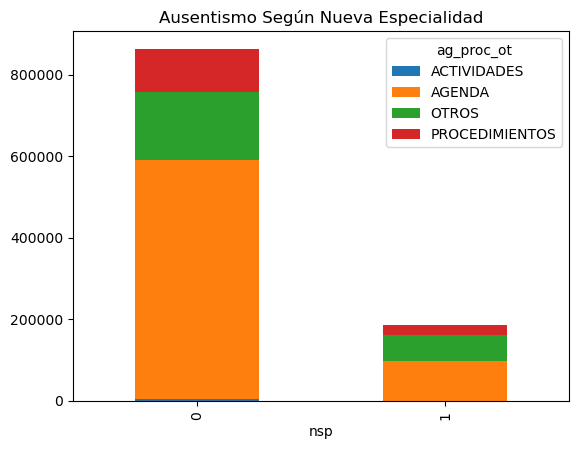

In [75]:
CategoryPlotter(data , "ag_proc_ot" , "nsp" , "Ausentismo Según Nueva Especialidad")

Como primera conclusión de lo anterior notamos que la mayor cantidad de ausentismos se da en el caso de las __AGENDAS MÉDICAS__, sin embargo, es importante entender esto en términos proporcionales ya que como la mayoría de las especialidades son __AGENDAS MÉDICAS__ es bastante probable que también tengan las mayores cantidades de ausentismos

In [76]:
tasa_ag_proc = CategoryAnalyzer(data , "ag_proc_ot" , "nsp")
tasa_ag_proc

nsp,0,1,Tasa
ag_proc_ot,,,
OTROS,168915,64828,27.73
PROCEDIMIENTOS,104683,23034,18.04
AGENDA,584936,96858,14.21
ACTIVIDADES,4827,482,9.08


Notamos que las especialidades vinculadas a __OTROS PROFESIONALES__ tienen una tasa de ausentismo de un 28% siendo la más alta seguida de __PROCEDIMIENTOS__. Además, las __ACTIVIDADES ODONTOLÓGICAS__ también poseen un 9% de ausentismo, lo cual no se puede ver en el gráfico, por eso siempre la importancia de combinar números con visualizaciones

#### __Sección 1.2.3 : Previsión__

De forma similar a lo anterior comenzamos viendo la variedad de los datos que componen esta variable

In [77]:
data.value_counts("prevision")

prevision
FONASA B                           576675
FONASA A                           244893
FONASA D                           116544
FONASA C                            99103
NO ESPECIFICADO                      5179
DIPRECA                              2075
COLMENA GOLDEN CROSS S.A.             771
AT. PARTICULAR                        717
CONSALUD S.A.                         563
MAS VIDA S.A.                         498
ISAPRE BANMEDICA S.A.                 425
ING SALUD ( EX CRUZ BLANCA S.A)       399
CAPREDENA                             357
JEAFOSALE                             120
FERROSALUD S.A.                        91
CIGNA SALUD ISAPRE S.A                 77
VIDA TRES S.A.                         63
F.A.S.T BANCO DEL ESTADO               13
dtype: int64

Notamos que hay __23__ categorías diferentes, de tal forma que es necesario realizar una limpieza pues hay algunas categorías que presentan 1 solo usuario de un universo de 1 millón por lo que se pueden eliminar. 

In [78]:
data = data[data["prevision"] != "FONASA"]

Primero calculamos una tasa para cada categoría:

In [79]:
(data.value_counts("prevision")/len(data) * 100)

prevision
FONASA B                           54.996695
FONASA A                           23.355106
FONASA D                           11.114640
FONASA C                            9.451316
NO ESPECIFICADO                     0.493914
DIPRECA                             0.197890
COLMENA GOLDEN CROSS S.A.           0.073529
AT. PARTICULAR                      0.068379
CONSALUD S.A.                       0.053693
MAS VIDA S.A.                       0.047494
ISAPRE BANMEDICA S.A.               0.040532
ING SALUD ( EX CRUZ BLANCA S.A)     0.038052
CAPREDENA                           0.034047
JEAFOSALE                           0.011444
FERROSALUD S.A.                     0.008679
CIGNA SALUD ISAPRE S.A              0.007343
VIDA TRES S.A.                      0.006008
F.A.S.T BANCO DEL ESTADO            0.001240
dtype: float64

Hay claramente 3 previsiones que predominan el set de datos __FONASA B, A y D__ que suman casi un 90% del total de datos. Analicemos el comportamiento de estas mayorías

In [80]:
datafon = data[(data["prevision"] == "FONASA B") | (data["prevision"] == "FONASA A") |
               (data["prevision"] == "FONASA D")]

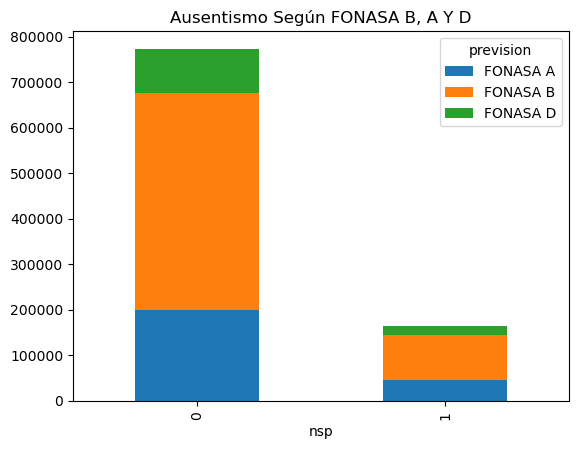

In [81]:
CategoryPlotter(datafon , "prevision" , "nsp" , "Ausentismo Según FONASA B, A Y D")

In [82]:
tasa_prev = CategoryAnalyzer(datafon , "prevision" , "nsp")
tasa_prev

nsp,0,1,Tasa
prevision,,,
FONASA A,198928,45965,18.77
FONASA D,96414,20130,17.27
FONASA B,478123,98552,17.09


Repetimos el proceso, pero para todas las previsiones

In [83]:
tasa_prev = CategoryAnalyzer(data , "prevision" , "nsp")
tasa_prev

nsp,0,1,Tasa
prevision,,,
CIGNA SALUD ISAPRE S.A,44,33,42.86
COLMENA GOLDEN CROSS S.A.,502,269,34.89
MAS VIDA S.A.,326,172,34.54
ING SALUD ( EX CRUZ BLANCA S.A),276,123,30.83
JEAFOSALE,84,36,30.00
AT. PARTICULAR,505,212,29.57
ISAPRE BANMEDICA S.A.,304,121,28.47
CONSALUD S.A.,415,148,26.29
NO ESPECIFICADO,3863,1316,25.41


Notamos que hay 5 previsiones que tienen __NaN__ las cuales obviamente corresponden a las 4 restantes, aparte de FONASA , y son aquellas que tienen muy pocos registros (menos de 5) como se vio arriba, por lo que debemos eliminarlas

In [84]:
eliminar_prev = ["CHUQUICAMATA LTDA" , "CRUZ DEL NORTE LTDA." , "NO ESPECIFICADO A" , "RIO BLANCO LTDA." ]

In [85]:
tasa_prev.dropna(inplace = True)

In [86]:
tasa_prev

nsp,0,1,Tasa
prevision,,,
CIGNA SALUD ISAPRE S.A,44,33,42.86
COLMENA GOLDEN CROSS S.A.,502,269,34.89
MAS VIDA S.A.,326,172,34.54
ING SALUD ( EX CRUZ BLANCA S.A),276,123,30.83
JEAFOSALE,84,36,30.00
AT. PARTICULAR,505,212,29.57
ISAPRE BANMEDICA S.A.,304,121,28.47
CONSALUD S.A.,415,148,26.29
NO ESPECIFICADO,3863,1316,25.41


Como variable adicional se van a crear categorías más macro, es decir, vamos a agrupar los datos según pertenencia a sistema de salud público, privado , fuerzas armadas , particular o no especificado. Para lo anterior, primero especificamos los conjuntos respectivos:

In [87]:
prev_dict = {
    'CIGNA SALUD ISAPRE S.A' : "Isapre" , 
    'COLMENA GOLDEN CROSS S.A.' : "Isapre", 
    'CONSALUD S.A.' : "Isapre" , 
    'F.A.S.T BANCO DEL ESTADO' : "Isapre", 
    'FERROSALUD S.A.' : "Isapre" , 
    'ING SALUD ( EX CRUZ BLANCA S.A)' : "Isapre",
    'ISAPRE BANMEDICA S.A.' : "Isapre" ,
    'MAS VIDA S.A.' : "Isapre" , 
    'VIDA TRES S.A.' : "Isapre" , 
    "CAPREDENA" : "FFAA" , 
    'DIPRECA' : "FFAA",
    'JEAFOSALE' : "FFAA",
    'FONASA A' : "Fonasa", 
    'FONASA B' : "Fonasa",
    'FONASA C' : "Fonasa", 
    'FONASA D' : "Fonasa" ,
    "NO ESPECIFICADO" : "No Espec" ,
    "AT. PARTICULAR" : "Particular"
}

Creamos la nueva variable:

In [88]:
prev2 = []
for x in data.prevision:
    try:
        prev2.append(prev_dict[x])
    except:
        prev2.append("Eliminar")
data["prevision2"] = prev2

In [89]:
data = data[data["prevision2"] != "Eliminar"]

Repetimos el análisis, esta vez viendo el resultado agrupado:

In [90]:
data.head(2)

,id,fechanacimiento,sexo,prevision,especialidad,tipoatencion,fechareserva,fechahoracita,nsp,ag_proc_ot,prevision2,MesReserva,MesConsulta,DeltaDias,Days60,DaysGroup,TasaProcedimiento,TasaPrevision,TasaDays
0,e1f568d43f199d828c9462e05c784c16,1965-05-18,f,FONASA C,GINECOLOGIA - AGENDA MEDICA,NUEVO,2018-11-12,2018-11-27 11:00:00,0,AGENDA,Fonasa,11,11,15,DaysNormal,G2,14.21,17.57,18.28
1,dbe9285fa3633f6baea7e382e3f120d0,1992-02-02,f,FONASA B,OBSTETRICIA - AGENDA MEDICA,CONTROL,2018-10-30,2018-11-13 10:30:00,1,AGENDA,Fonasa,10,11,14,DaysNormal,G2,14.21,17.57,18.28


In [91]:
tasa_prev_agreg = CategoryAnalyzer(data , "prevision2" , "nsp")
tasa_prev_agreg

nsp,0,1,Tasa
prevision2,,,
Isapre,2004,896,30.90
Particular,505,212,29.57
No Espec,3863,1316,25.41
FFAA,2039,513,20.10
Fonasa,854950,182265,17.57


Por lo tanto en términos generales nos damos cuenta que la tasa de ausentismo en Isapre y Particular es un poco menos del doble que la atención en Fonasa. Esto podría deberse, tal vez, a que las personas con isapre tienen accesos más fáciles a atenciones de diferente tipo, a diferencia de aquellos en Fonasa que, como ya sabemos hay una gran lista de espera

#### __Sección 1.2.4 : Fecha Reserva y Fecha Cita__

Como vimos al comienzo del EDA, las variables de fecha ya están en formato __Timestamp__ por lo que es bastante fácil crear nuevas variables. Primero identificaremos los meses en los que se enmarcan ambas fechas y además identificaremos cuánto tiempo ocurre desde la fecha de Reserva hasta la Fecha de Consulta y analizaremos si hay algún efecto según la diferencia en días de ambos

In [92]:
data["MesReserva"] = [x.month for x in data.fechareserva]
data["MesConsulta"] = [x.month for x in data.fechahoracita]
data["DeltaDias"] = [x.days for x in (data["fechahoracita"] - data["fechareserva"])]

Comenzando con la __Diferencia de Días__ visualizamos la distribución de los datos con un __Histograma__

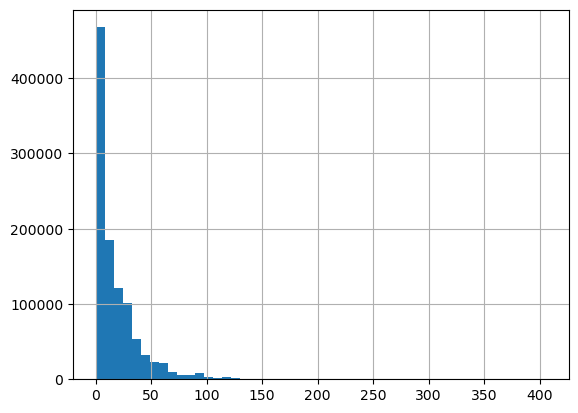

In [93]:
data.DeltaDias.hist(bins = 50);

Notamos la gran presencia de ciertos __Outliers__ o __Puntos Atípicos__ ya que hay una gran densidad de puntos entre 0 y 150, pero el gráfico se alarga hasta 400. Acotemos un poco los días. Crearemos algunas categorías base. Si establecemos como punto de obserrvación __60 días__ el histograma se ve de la siguiente forma: 

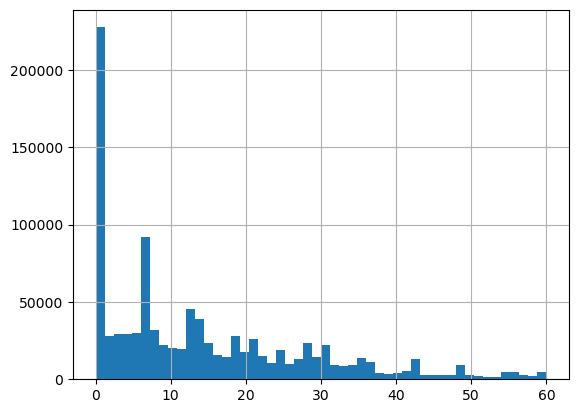

In [94]:
data[data["DeltaDias"] <= 60].DeltaDias.hist(bins = 50);

Por ende, para el análisis divideremos los datos en dos. Una parte son todos aquellos en los que la diferencia en días es de 60 o menos y otro de 60 o más.

In [95]:
data["Days60"] = ["DaysNormal" if x <= 60 else "DaysExceso" for x in data.DeltaDias]

In [96]:
data.value_counts("Days60")

Days60
DaysNormal    995157
DaysExceso     53406
dtype: int64

Procedemos a analizar el primer grupo, aquellos pacientes en los que la diferencia entre la fecha de la reserva y la fecha de la cita es menor o igual a 60

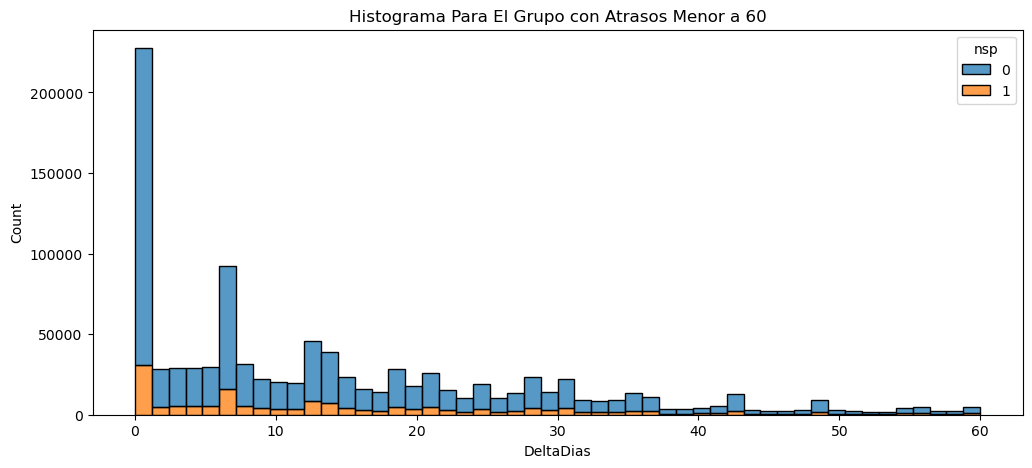

In [ ]:
plt.figure(figsize = (12,5))
plt.title("Histograma Para El Grupo con Atrasos Menor a 60")
sns.histplot(data = data[data["Days60"] == "DaysNormal"], x='DeltaDias' , bins =50 , hue = "nsp" , multiple = "stack");

Notamos que la mayor tasa de ausentismos, por lo menos visualmente, se presenta cuando la Fecha de Reserva y la Fecha de Consulta es la misma, es decir, el mismo día. Es más, la mayoría de los ausentismos se concentran cuando la diferencia es en 10 días. Por lo tanto vamos a reclasificar a los pacientes y los agruparemos según diferencia de días en grupos de 10 en 10:

In [ ]:
data_60_norm = data[data["Days60"] == "DaysNormal"]
data_60_excess = data[data["Days60"] != "DaysNormal"]

# __REVISAR COMO HACER BINNING DE UNA FORMA MENOS MANUAL__

In [ ]:
days_group = []
for x in data_60_norm.DeltaDias:
    if x <= 10 :
        days_group.append("G1")
    elif 10 < x <= 20:
        days_group.append("G2")
    elif 20 < x <= 30:
        days_group.append("G3")
    elif 30 < x <= 40:
        days_group.append("G4")
    elif 40 < x <= 50:
        days_group.append("G5")
    elif 50 < x <= 60:
        days_group.append("G6")
data_60_norm["DaysGroup"] = days_group

C:\Users\Marcelojtc\AppData\Local\Temp\ipykernel_4364\1607556005.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_60_norm["DaysGroup"] = days_group


In [ ]:
data_60_norm.value_counts("DaysGroup")

DaysGroup
G1    510002
G2    203433
G3    143581
G4     73505
G5     40500
G6     24136
dtype: int64

In [ ]:
tasa_days_group60 = CategoryAnalyzer(data_60_norm , "DaysGroup" , "nsp")
tasa_days_group60

nsp,0,1,Tasa
DaysGroup,,,
G5,32281,8219,20.29
G6,19317,4819,19.97
G4,59629,13876,18.88
G3,116709,26872,18.72
G2,166236,37197,18.28
G1,428507,81495,15.98


Repetimos el mismo proceso para aquellos pacientes con diferencia de días mayor a 60

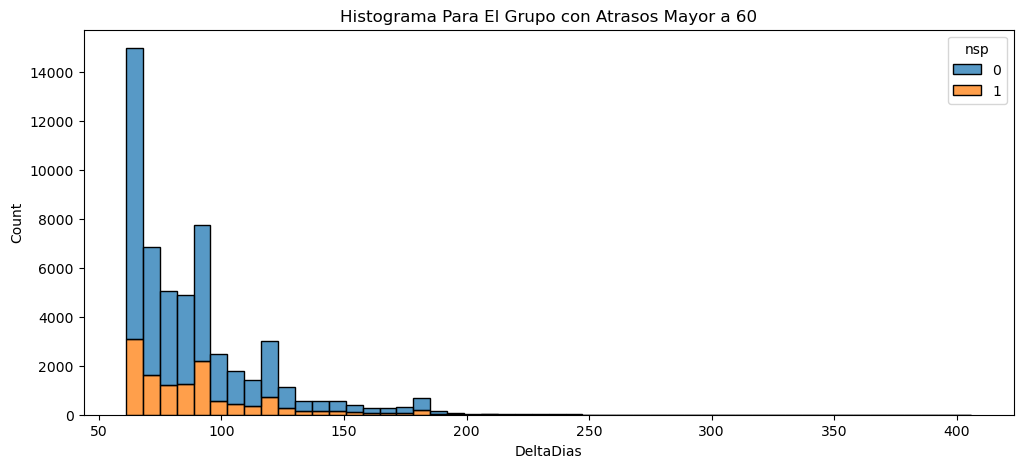

In [ ]:
plt.figure(figsize = (12,5))
plt.title("Histograma Para El Grupo con Atrasos Menor a 60")
sns.histplot(data = data[data["Days60"] == "DaysExceso"], x='DeltaDias' , bins =50 , hue = "nsp" , multiple = "stack");

En este caso, solo haremos tres divisiones:  
* Grupo Mayor a 60 y Menor a 100
* Grupo Mayor a 100 y Menor a 150
* Grupo Mayor a 150

In [110]:
days_group = []
for x in data_60_excess.DeltaDias:
    if 60 < x <= 100 :
        days_group.append("G7")
    elif 100 < x <= 150:
        days_group.append("G8")
    else:
        days_group.append("G9")
data_60_excess["DaysGroup"] = days_group

In [111]:
tasa_days_group60ex = CategoryAnalyzer(data_60_excess , "DaysGroup" , "nsp")
tasa_days_group60ex

nsp,0,1,Tasa
DaysGroup,,,
G9,1850,617,25.01
G8,7081,2282,24.37
G7,31751,9825,23.63


Si concatenamos todos los resultados obtenemos lo siguiente:

In [112]:
tasas_days = pd.concat([tasa_days_group60 , tasa_days_group60ex]).sort_values(by = "Tasa" , ascending = False)
tasas_days

nsp,0,1,Tasa
DaysGroup,,,
G9,1850,617,25.01
G8,7081,2282,24.37
G7,31751,9825,23.63
G5,32281,8219,20.29
G6,19317,4819,19.97
G4,59629,13876,18.88
G3,116709,26872,18.72
G2,166236,37197,18.28
G1,428507,81495,15.98


In [113]:
orig_data = data.copy()

Podemos entonces concluir que hay una mayor tasa de ausentismo en aquellos pacientes que son agendados con más de 100 días desde la reserva. Pueden existir diversos factores, algo tan simple como por ejemplo, simplemente se les olvidó o en un caso más complejo que el paciente falleció por ejemplo

In [114]:
data = pd.concat([data_60_norm , data_60_excess])

In [115]:
data.head()

,id,fechanacimiento,sexo,prevision,especialidad,tipoatencion,fechareserva,fechahoracita,nsp,ag_proc_ot,prevision2,MesReserva,MesConsulta,DeltaDias,Days60,DaysGroup,TasaProcedimiento,TasaPrevision,TasaDays
0,e1f568d43f199d828c9462e05c784c16,1965-05-18,f,FONASA C,GINECOLOGIA - AGENDA MEDICA,NUEVO,2018-11-12,2018-11-27 11:00:00,0,AGENDA,Fonasa,11,11,15,DaysNormal,G2,14.21,17.57,18.28
1,dbe9285fa3633f6baea7e382e3f120d0,1992-02-02,f,FONASA B,OBSTETRICIA - AGENDA MEDICA,CONTROL,2018-10-30,2018-11-13 10:30:00,1,AGENDA,Fonasa,10,11,14,DaysNormal,G2,14.21,17.57,18.28
2,27b54f22d85a9ffd835c31bdd8277548,1996-07-20,f,FONASA A,OBSTETRICIA - AGENDA MEDICA,CONTROL,2018-10-24,2018-11-06 10:15:00,0,AGENDA,Fonasa,10,11,13,DaysNormal,G2,14.21,17.57,18.28
3,f1d708b68b86fed7f71d8fefca787666,1986-07-22,f,FONASA D,OBSTETRICIA - AGENDA MEDICA,CONTROL,2018-11-12,2018-11-29 10:15:00,0,AGENDA,Fonasa,11,11,17,DaysNormal,G2,14.21,17.57,18.28
4,0c3797e1511d2e170ae83aaea1db774a,1978-10-06,f,FONASA B,OBSTETRICIA - AGENDA MEDICA,CONTROL,2018-11-12,2018-11-28 10:00:00,0,AGENDA,Fonasa,11,11,16,DaysNormal,G2,14.21,17.57,18.28


## __Conclusiones del EDA__

* __Total Datos__ : 1048563
* __18%__ De Desbalanceo
* __Tipo Atención__: Principales son CONTROL y NUEVO (775K). Mayores atrasos : Peritaje y autorizado cuaderno
* __Sexo__ : no hay gran diferencia entre hombres y mujeres
* __Especialidad__: La mayoría es AGENDA. Mayor atraso OTROS PROFESIONALES
* __Previsión__ : 80% del set es FONASA. Mayor ausentismo en ISAPRE y PARTICULAR
* __Fechas__ : cuando la diferencia entre la agenda y la consulta es mayor a 60 días, hay mayor ausentismo 

## __Ideas para los Modelos__

* Hacer más de un modelo, ya sean modelos en paralelo o en serie
* A partir del EDA haría un modelo para pacientes FONASA y otro para el resto. Esto por dos razones: la primera porque la gran mayoría del set son pacientes de FONASA y la segunda porque a través del EDA vimos que en el caso de servicios privados el ausentismo es un poco menos que el doble.
* Dado el gran desbalanceo de clases accuracy no es la medida adecuada, por lo que hay que mirar otras como __Precisión y Recall__
* En este caso debemos privilegiar la __Precisión__. La razón es sencilla: un __Falso Positivo__ nos va a dañar más que un __Falso Negativo__. Aplicado a un ejemplo: si decimos que un paciente se va a ausentar y le cancelamos la hora, pero el paciente llega entonces le haremos un gran daño al paciente que puede estar esperando la hora desde hace tiempo (Precisión Baja). Por otra parte si decimos que un paciente __NO__ se va a ausentar y finalmente se ausenta, entonces simplemente perderemos una hora ya tomada por lo que el daño no sería tan grave (Sensibilidad Baja).
* Debido a desbalanceo además debemos buscar técnicas como __SMOTE , undersampling u oversampling__ para tratar de subsanar este problema 